Importing Packages

In [266]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor

Reading File

In [267]:
# Importing the dataset
df = pd.read_csv('Energy_consumption.csv')

# Converting the 'Timestamp' column to datetime format and setting it as the index
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp')
df.set_index('Timestamp', inplace=True)

# Correcting Day of Week
df['DayOfWeek'] = df.index.day_name()

# Saving the original columns for later use
original_columns = df.columns.tolist()

Feature enginnering. Since we plan to model time series data via XGBoost, lagged featured need to be created.  

In [ ]:
# -------  Engineering features for time series modelling without weather info using XGBoost------- #

df['lag_1'] = df['EnergyConsumption'].shift(1) # lag 1 hour
df['lag_24'] = df['EnergyConsumption'].shift(24) # lag 24 hours
df['hour'] = df.index.hour # hour of the day
    # More features can be added here as per requirement

engineered_features = [col for col in df.columns if col not in original_columns]  # list of engineered features

# ------- Engineering features for time series modelling with weather info as external variable using XGBoost------#

#df['lag_24_Temp'] = df['Temperature'].shift(24) # lag 24 hours for temperature
#df['lag_24_Humidity'] = df['Humidity'].shift(24)
    # More features can be added here as per requirement
    # Removed lag_24 features as it didn't significantly improve the model performance
    

engineered_features_2 = [col for col in df.columns if col not in original_columns and col not in engineered_features]
 # list of engineered features but excluding the ones created for previous model
engineered_features_weather = engineered_features_2 + ['Temperature', 'Humidity']
# Adding the temperature from original column to the list of engineered features

#---------------------------

df = df.dropna()

# Engineering features created to way so that modification or additions to the engineered features can be done easily and on one line

Splitting data into train and test sets

In [270]:
# Choosing size training and testing data
split_index = int(len(df) * 0.8) # 80% of the data for training
test_size = int(len(df) - split_index) # 20% of the data for testing


# Splitting the data into training and testing sets (80% train, 20% test)
df_train = df.iloc[:split_index] # training set
df_test = df.iloc[split_index:] # test set
   

Time series model without temperature using XGBoost

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.6}


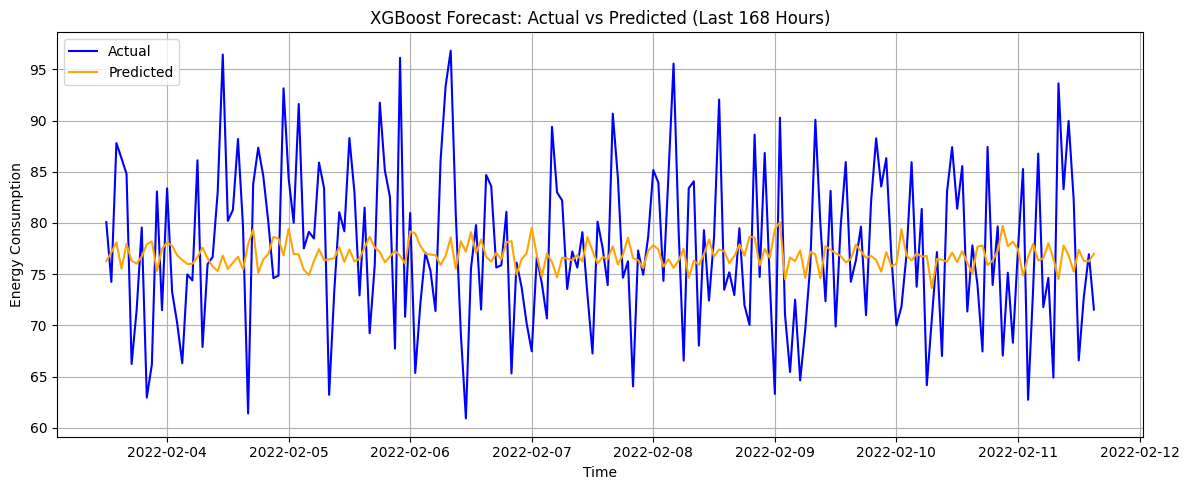

MAE:  6.64
RMSE: 8.10
MAPE: 8.58%
R²:   -0.0713


In [ ]:
# Creating and splitting the features and target variables
X_train = df_train[engineered_features]
y_train = df_train['EnergyConsumption']
X_test = df_test[engineered_features]
y_true = df_test['EnergyConsumption']

# Preparing the model for XGBoost
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
tscv = TimeSeriesSplit(n_splits=5)

# === Grid Search ===
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1, 0.5],
    'subsample': [0.6, 0.8, 1.0]
}

xgb = XGBRegressor(random_state=42)
tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Use the best model to predict
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print best parameters
print("Best parameters:", grid_search.best_params_)

# ===  Plot Actual vs Predicted ===
plt.figure(figsize=(12, 5))
plt.plot(df.index[split_index:], df['EnergyConsumption'].iloc[split_index:], label='Actual', color='blue')
plt.plot(y_true.index, y_pred, label='Predicted', color='orange')
plt.title('XGBoost Forecast: Actual vs Predicted (Last 168 Hours)')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred) ** 0.5
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.4f}")

The XGBoost model is underfitting the data, as shown by its smooth predictions that miss the sharp fluctuations in actual energy consumption. The negative R² value and moderate error metrics (MAE: 6.64, RMSE: 8.10, MAPE: 8.58%) confirm poor performance, meaning the model does worse than simply predicting the mean.

Without weather data, the energyconsumption data looks similar to white noise. 

Time series model with weather data as external variable using XGBoost

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.8}


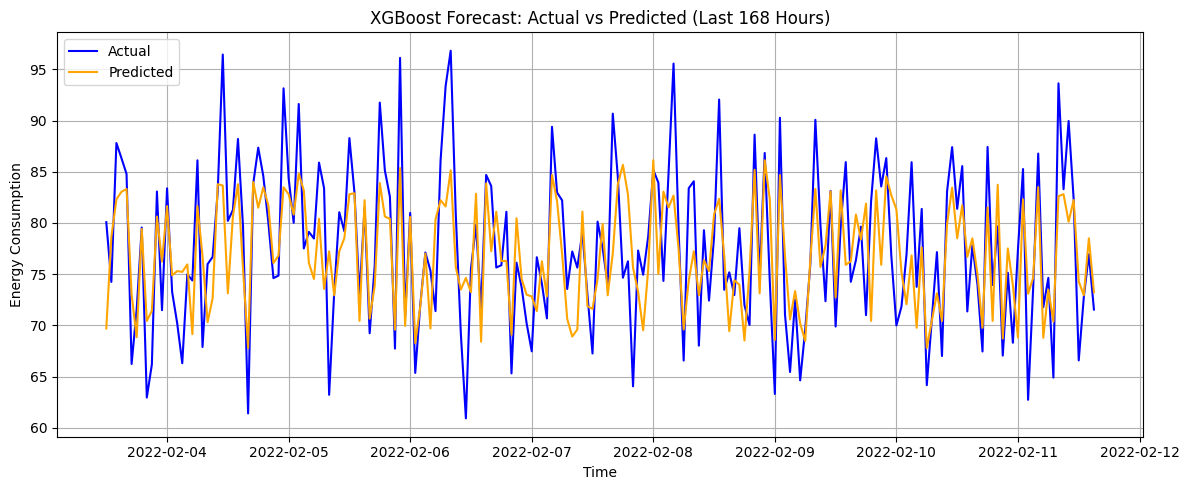

MAE:  4.44
RMSE: 5.53
MAPE: 5.75%
R²:   0.5005


In [ ]:
# Creating and spliting the feature and target variables
X_train = df_train[engineered_features_weather]
y_train = df_train['EnergyConsumption']
X_test = df_test[engineered_features_weather]
y_true = df_test['EnergyConsumption']

# Preparing the model for XGBoost

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
tscv = TimeSeriesSplit(n_splits=5)

# === Grid Search ===
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'subsample': [0.6, 0.8, 1.0]
}

xgb = XGBRegressor(random_state=42)
tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Use the best model to predict
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print best parameters
print("Best parameters:", grid_search.best_params_)

# === Step 4: Plot Actual vs Predicted ===
plt.figure(figsize=(12, 5))
plt.plot(df.index[split_index:], df['EnergyConsumption'].iloc[split_index:], label='Actual', color='blue')
plt.plot(y_true.index, y_pred, label='Predicted', color='orange')
plt.title('XGBoost Forecast: Actual vs Predicted (Last 168 Hours)')
plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred) ** 0.5
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.4f}")

The updated XGBoost model, now including weather information, shows a clear improvement in performance. The predicted curve (orange) better tracks the actual energy consumption (blue), capturing more of the short-term fluctuations. This is reflected in the significantly better metrics: lower errors (MAE: 4.44, RMSE: 5.53, MAPE: 5.75%) and a much stronger R² of 0.50, meaning the model now explains 50% of the variance in energy usage. 

Incorporating weather data clearly improved the model’s ability to capture real-world variations in energy demand. Since weather forecasts are typically available several days in advance, using this information makes the model both practical and valuable for short-term forecasting.

Now we consider a model where all non-target columns in original data are used as features using Random Forest 
First, we consider which features to drop before trainning the the best model 

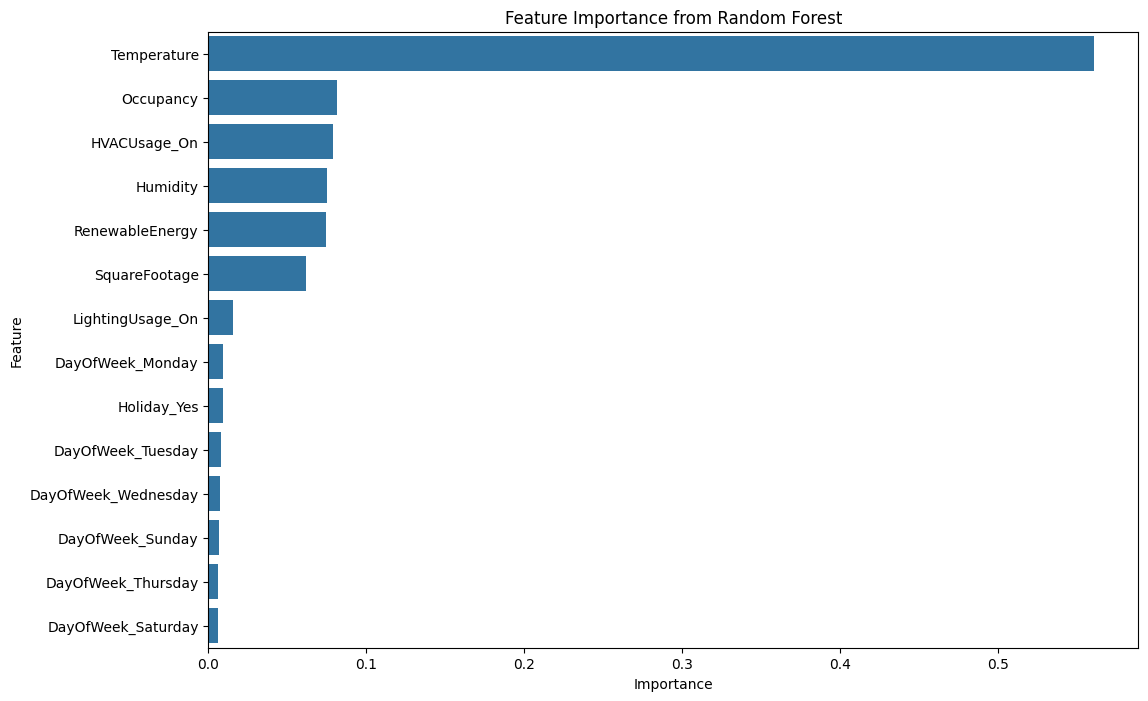

In [275]:
# Collecting previous engineered features columns to drop
eng_features_to_drop = engineered_features + engineered_features_2
col_drop = [col for col in df.columns if col in eng_features_to_drop] # Checks if the features to drop are in the dataframe
if col_drop:
    df = df.drop(columns=eng_features_to_drop)
# Only removes features that are in the dataframe. 
# This prevenrts errors if the features are not in the dataframe    

# One-hot encode remaining categorical variables
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
one_hot_encoded_columns = [col for col in df.columns if col not in original_columns]

# Convert boolean columns to integers
boolean_columns = df.select_dtypes(include='bool').columns
df[boolean_columns] = df[boolean_columns].astype(int)

# Splitting the data into feature set and target variable
X = df.drop(columns='EnergyConsumption')
y = df['EnergyConsumption']

# Split features and target
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]


# Train a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
feature_importances = rf.feature_importances_
features = X.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance from Random Forest')
plt.show()

Now, we drop the least important features and do a grid search to find and train the best model.

In [276]:
# Filter features with importance < 0.5
low_importance_features = feature_importance_df[feature_importance_df['Importance'] < 0.05]['Feature'].values

print("Low importance features:", low_importance_features)  

# Drop low importance features that are also in X
X2_train = X_train.drop(columns=low_importance_features)
X2_test = X_test.drop(columns=low_importance_features)


# Train a Random Forest model using parameter tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    # Add more hyperparameters to tune if needed
}

# Initialize GridSearchCV hyperparameters
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5,  # Number of cross-validation folds
                           verbose=1,
                           n_jobs=-1  # Use all processors
                          )

# Fit GridSearchCV
grid_search.fit(X2_train, y_train)

# Get the best hyperparameters and the best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_tuned = best_model.predict(X2_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred_tuned)
rmse = mean_squared_error(y_test, y_pred_tuned) ** 0.5
mape = np.mean(np.abs((y_test - y_pred_tuned) / y_test)) * 100
r2 = r2_score(y_test, y_pred_tuned)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.4f}")

Low importance features: ['LightingUsage_On' 'DayOfWeek_Monday' 'Holiday_Yes' 'DayOfWeek_Tuesday'
 'DayOfWeek_Wednesday' 'DayOfWeek_Sunday' 'DayOfWeek_Thursday'
 'DayOfWeek_Saturday']
Fitting 5 folds for each of 27 candidates, totalling 135 fits
MAE:  4.21
RMSE: 5.15
MAPE: 5.45%
R²:   0.5674


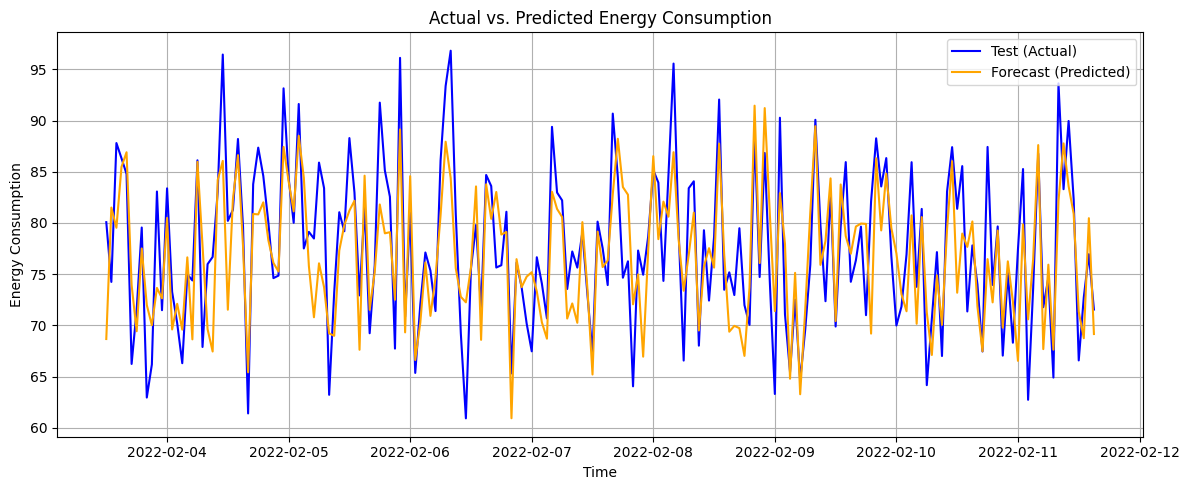

In [277]:
plt.figure(figsize=(12, 5))

# Plot test values
plt.plot(y_test.index, y_test.values, label='Test (Actual)', color='blue', marker='')

# Plot predictions 
plt.plot(y_test.index, y_pred_tuned, label='Forecast (Predicted)', color='orange', marker='')

plt.xlabel('Time')
plt.ylabel('Energy Consumption')
plt.title('Actual vs. Predicted Energy Consumption')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This updated model shows further improvement in performance, with tighter alignment between the predicted (orange) and actual (blue) energy consumption curves. The forecast now captures both short-term fluctuations and broader trends more effectively. Error metrics have improved again (MAE: 4.21, RMSE: 5.15, MAPE: 5.45%), and the R² has increased to 0.5674, indicating the model now explains over 56% of the variance in energy use. 

However, this model may only be reliable for short-term forecasts, as many of its input features—such as recent energy trends or environmental variables—are difficult to predict accurately beyond a few hours or days. This limits its usefulness for long-term planning but makes it well-suited for near-term operational decisions.